***Before running this notebook, make sure you have kaggle.json file in your home directory***

In [2]:
# Import libraries

import pandas as                          pd
import numpy as                           np
import matplotlib.pyplot as               plt
import                                    random
import tensorflow as                      tf
from sklearn.model_selection import       train_test_split
from sklearn.preprocessing import         LabelEncoder

KeyboardInterrupt: 

# Load and Visualize 

In [7]:
!kaggle competitions download -c store-sales-time-series-forecasting


  0%|          | 0.00/21.4M [00:00<?, ?B/s]
  5%|▍         | 1.00M/21.4M [00:00<00:03, 6.04MB/s]
 23%|██▎       | 5.00M/21.4M [00:00<00:00, 21.2MB/s]
 37%|███▋      | 8.00M/21.4M [00:00<00:00, 23.3MB/s]
 70%|███████   | 15.0M/21.4M [00:00<00:00, 37.5MB/s]
 94%|█████████▎| 20.0M/21.4M [00:00<00:00, 40.5MB/s]
100%|██████████| 21.4M/21.4M [00:00<00:00, 33.4MB/s]


In [8]:
import zipfile 
import os 

archive = zipfile.ZipFile('store-sales-time-series-forecasting.zip')

for file in archive.namelist():
    archive.extract(file, 'kaggle-dataset')

In [12]:
os.remove("store-sales-time-series-forecasting.zip")

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'store-sales-time-series-forecasting.zip'

In [32]:
# Load data

train_dataset = pd.read_csv(r'kaggle-dataset\train.csv') 
test_data = pd.read_csv(r'kaggle-dataset\test.csv')

# Sub data
oil_data = pd.read_csv(r'kaggle-dataset\oil.csv')
holiday_events = pd.read_csv(r'kaggle-dataset\holidays_events.csv') 
stores_csv = pd.read_csv(r'kaggle-dataset\stores.csv')
# Note: We are not using transactions.csv since it doesn't contain data for test.csv

train_dataset[:3]

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [33]:
print(f"Min sales: {min(train_dataset['sales'])}")
print(f"Max sales: {max(train_dataset['sales'])}")
print(f"Mean sales: {np.mean(train_dataset['sales'])}")
print(f"Train shape: {train_dataset.shape}")
print(f"Test shape: {test_data.shape}")
print(f"There are {len(train_dataset['sales'][train_dataset['sales'] > 0].unique())} unique values of sales in train data")
print(f"There are {len(train_dataset['sales'][train_dataset['sales'] == 0])} rows with 0 sales in train data")
print(f"There are {len(train_dataset['family'].unique())} unique families")

# Dtypes 
train_dataset.dtypes

Min sales: 0.0
Max sales: 124717.0
Mean sales: 357.77574911261894
Train shape: (3000888, 6)
Test shape: (28512, 5)
There are 379609 unique values of sales in train data
There are 939130 rows with 0 sales in train data
There are 33 unique families


id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

# Preprocess data

In [34]:
# Check is there any missing values
print(f"Missing values for oil data: {oil_data.isna().sum().sum()}")
print(f"Missing values for holiday data: {holiday_events.isna().sum().sum()}")
print(f"Missing values for stores data: {stores_csv.isna().sum().sum()}")

Missing values for oil data: 43
Missing values for holiday data: 0
Missing values for stores data: 0


In [35]:
# Pandas is needed

def fill_missing_values(dataset_column, decimals: int = 2):
    """ 
    Iterating through the dataset and filling the missing values by mean of previous and next value
    
    Args:
        dataset_column (pandas.DataFrame): Column with missing values to fill
        decimals (int, optional): Number of decimal places to round to
    
    Returns:
        pandas.DataFrame: The filled dataset
    """
    
    # Avoid aliasing
    dataset_column = dataset_column.copy()
    
    # Usual change is the mean of changes in values.
    usual_change = round(dataset_column.diff().dropna().mean(), decimals) # Mean change for every value in the column dataset

    for i in range(0, len(dataset_column)):
        
        if not pd.isna(dataset_column[i]):
            continue
        
        if i == 0 and pd.isna(dataset_column[i]):
            first_valid_index = dataset_column.first_valid_index()
            dataset_column[i] = dataset_column[first_valid_index] - usual_change
                
        elif i == len(dataset_column) - 1:
            if pd.isna(dataset_column[i]):
                dataset_column[i] = dataset_column[i - 1] + usual_change
                            
            # If the last value is not missing, return already filled column
            return dataset_column
        # Handling values in between                            FIX 
        else:
            previous_value = dataset_column[i - 1]
            next_value = dataset_column[i + 1]

            
            if pd.isna(next_value):
                next_value = dataset_column[dataset_column[i+1:].first_valid_index()]
                # If next_value wasn't found, then add the usual change
                if pd.isna(next_value):
                    dataset_column[i] = previous_value + usual_change
                    continue
            dataset_column[i] = round((previous_value + next_value) / 2, 2)
            
    return dataset_column

## **Sub Data: Row Inserting and Processing** 

Let's find all the **"date"** rows that our **oil_price** dataset doesn't have compared with our main datasets. It will help in future with filling our main datasets

In [36]:
# A function that will sync data column in sub data with our training and test data
def sync_data_column(sub_data, train_data, test_data):
    """ 
    This function will sync data column in sub data with our training and test data
    
    Args:
        sub_data (pandas.DataFrame) : The sub data to sync
        train_data (pandas.DataFrame): The training data
        test_data (pandas.DataFrame): The test data
    
    Returns:
        pandas.DataFrame: provided sub_data with added date columns (Synced columns will contain missing values)
    """

    missing_dates_train = train_dataset[~train_dataset['date'].isin(sub_data['date'])]['date'].unique()
    missing_dates_test = test_data[~test_data['date'].isin(sub_data['date'])]['date'].unique()

    missing_dates_train = pd.DataFrame(missing_dates_train, columns=['date'])
    missing_dates_test = pd.DataFrame(missing_dates_test, columns=['date'])

    # Fill for train and test
    sub_data = pd.concat([sub_data, missing_dates_train], ignore_index=True).sort_values(by='date').reset_index(drop=True)
    sub_data = pd.concat([sub_data, missing_dates_test], ignore_index=True).sort_values(by='date').reset_index(drop=True)


    return sub_data

### Preprocess oil.csv

In [37]:
%%time
# Sync oil data with train and test dataset
oil_data = sync_data_column(oil_data, train_dataset, test_data)
print(f"Missing values for oil data before: {oil_data.isna().sum().sum()}")

# Fill missing values
oil_data["oil_price"] = fill_missing_values(oil_data["dcoilwtico"])
oil_data.drop(columns=["dcoilwtico"], axis=1, inplace=True)

print(f"Missing values for oil data after: {oil_data.isna().sum().sum()}")

oil_data.head(10)

Missing values for oil data before: 528
Missing values for oil data after: 0
CPU times: total: 234 ms
Wall time: 268 ms


,date,oil_price
0,2013-01-01,93.13
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.16
5,2013-01-06,93.18
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


### Preprocess holidays data

## **Preprocessing Main Datasets**

In [39]:
def get_categorical_features(df, threshold=35):
    categorical_columns = df.select_dtypes(exclude=[np.number]).columns
    categorical_columns = [column for column in categorical_columns if threshold >= df[column].nunique()]
    return categorical_columns

In [40]:
def get_numerical_features(df, threshold=35):
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    numerical_columns = [column for column in numerical_columns if df[column].nunique() >= threshold]
    return numerical_columns

In [41]:
%%time
train_dataset['date'] = pd.to_datetime(train_dataset['date']).astype('datetime64[ns]')
test_data['date'] = pd.to_datetime(test_data['date']).astype('datetime64[ns]')
oil_data['date'] = pd.to_datetime(oil_data['date']).astype('datetime64[ns]')
holiday_events['date'] = pd.to_datetime(holiday_events['date']).astype('datetime64[ns]')

train_dataset = train_dataset.merge(oil_data, on="date", how="left")
train_dataset = train_dataset.merge(holiday_events, on="date", how="left")
train_dataset = train_dataset.merge(stores_csv, on="store_nbr", how="left")

test_data = test_data.merge(oil_data, on="date", how="left")
test_data = test_data.merge(holiday_events, on="date", how="left")
test_data = test_data.merge(stores_csv, on="store_nbr", how="left")


# Label Encode Categorical Features
categorical_features = get_categorical_features(train_dataset)

encoder = LabelEncoder()
train_dataset[categorical_features] = train_dataset[categorical_features].apply(encoder.fit_transform)
test_data[categorical_features] = test_data[categorical_features].apply(encoder.fit_transform)

print(f"Missing values for train dataset: {train_dataset.isna().sum().sum()}")
print(f"Missing values for test dataset: {test_data.isna().sum().sum()}")
train_dataset.head(10)


Missing values for train dataset: 0
Missing values for test dataset: 0
CPU times: total: 3.77 s
Wall time: 6.57 s


,id,date,store_nbr,family,sales,onpromotion,oil_price,type_x,locale,locale_name,transferred,city,state,type_y,cluster
0,0,2013-01-01,1,0,0.0,0,93.13,3,1,4,0,18,12,3,13
1,1,2013-01-01,1,1,0.0,0,93.13,3,1,4,0,18,12,3,13
2,2,2013-01-01,1,2,0.0,0,93.13,3,1,4,0,18,12,3,13
3,3,2013-01-01,1,3,0.0,0,93.13,3,1,4,0,18,12,3,13
4,4,2013-01-01,1,4,0.0,0,93.13,3,1,4,0,18,12,3,13
5,5,2013-01-01,1,5,0.0,0,93.13,3,1,4,0,18,12,3,13
6,6,2013-01-01,1,6,0.0,0,93.13,3,1,4,0,18,12,3,13
7,7,2013-01-01,1,7,0.0,0,93.13,3,1,4,0,18,12,3,13
8,8,2013-01-01,1,8,0.0,0,93.13,3,1,4,0,18,12,3,13
9,9,2013-01-01,1,9,0.0,0,93.13,3,1,4,0,18,12,3,13


### Additional Note: Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

In [42]:
def is_last_day_of_month(date):
    next_day = date + pd.Timedelta(days=1)
    return next_day.month != date.month

train_df = train_dataset.copy()
test_df = train_dataset.copy()

# Add new columns for wage payment indicators
train_df['Is_15th'] = train_df['date'].dt.day == 15
train_df['Is_Last_Day'] = train_df['date'].apply(is_last_day_of_month)

test_df['Is_15th'] = train_df['date'].dt.day == 15
test_df['Is_Last_Day'] = train_df['date'].apply(is_last_day_of_month)

# Concatenate into one column 
train_dataset["WageDay"] = train_df['Is_15th'] | train_df['Is_Last_Day']
test_data["WageDay"] = test_df['Is_15th'] | test_df['Is_Last_Day']

del train_df
del test_df

train_dataset["WageDay"]

0          False
1          False
2          False
3          False
4          False
           ...  
3054343     True
3054344     True
3054345     True
3054346     True
3054347     True
Name: WageDay, Length: 3054348, dtype: bool

## Deal with skewness

Total Skewed Features: 5


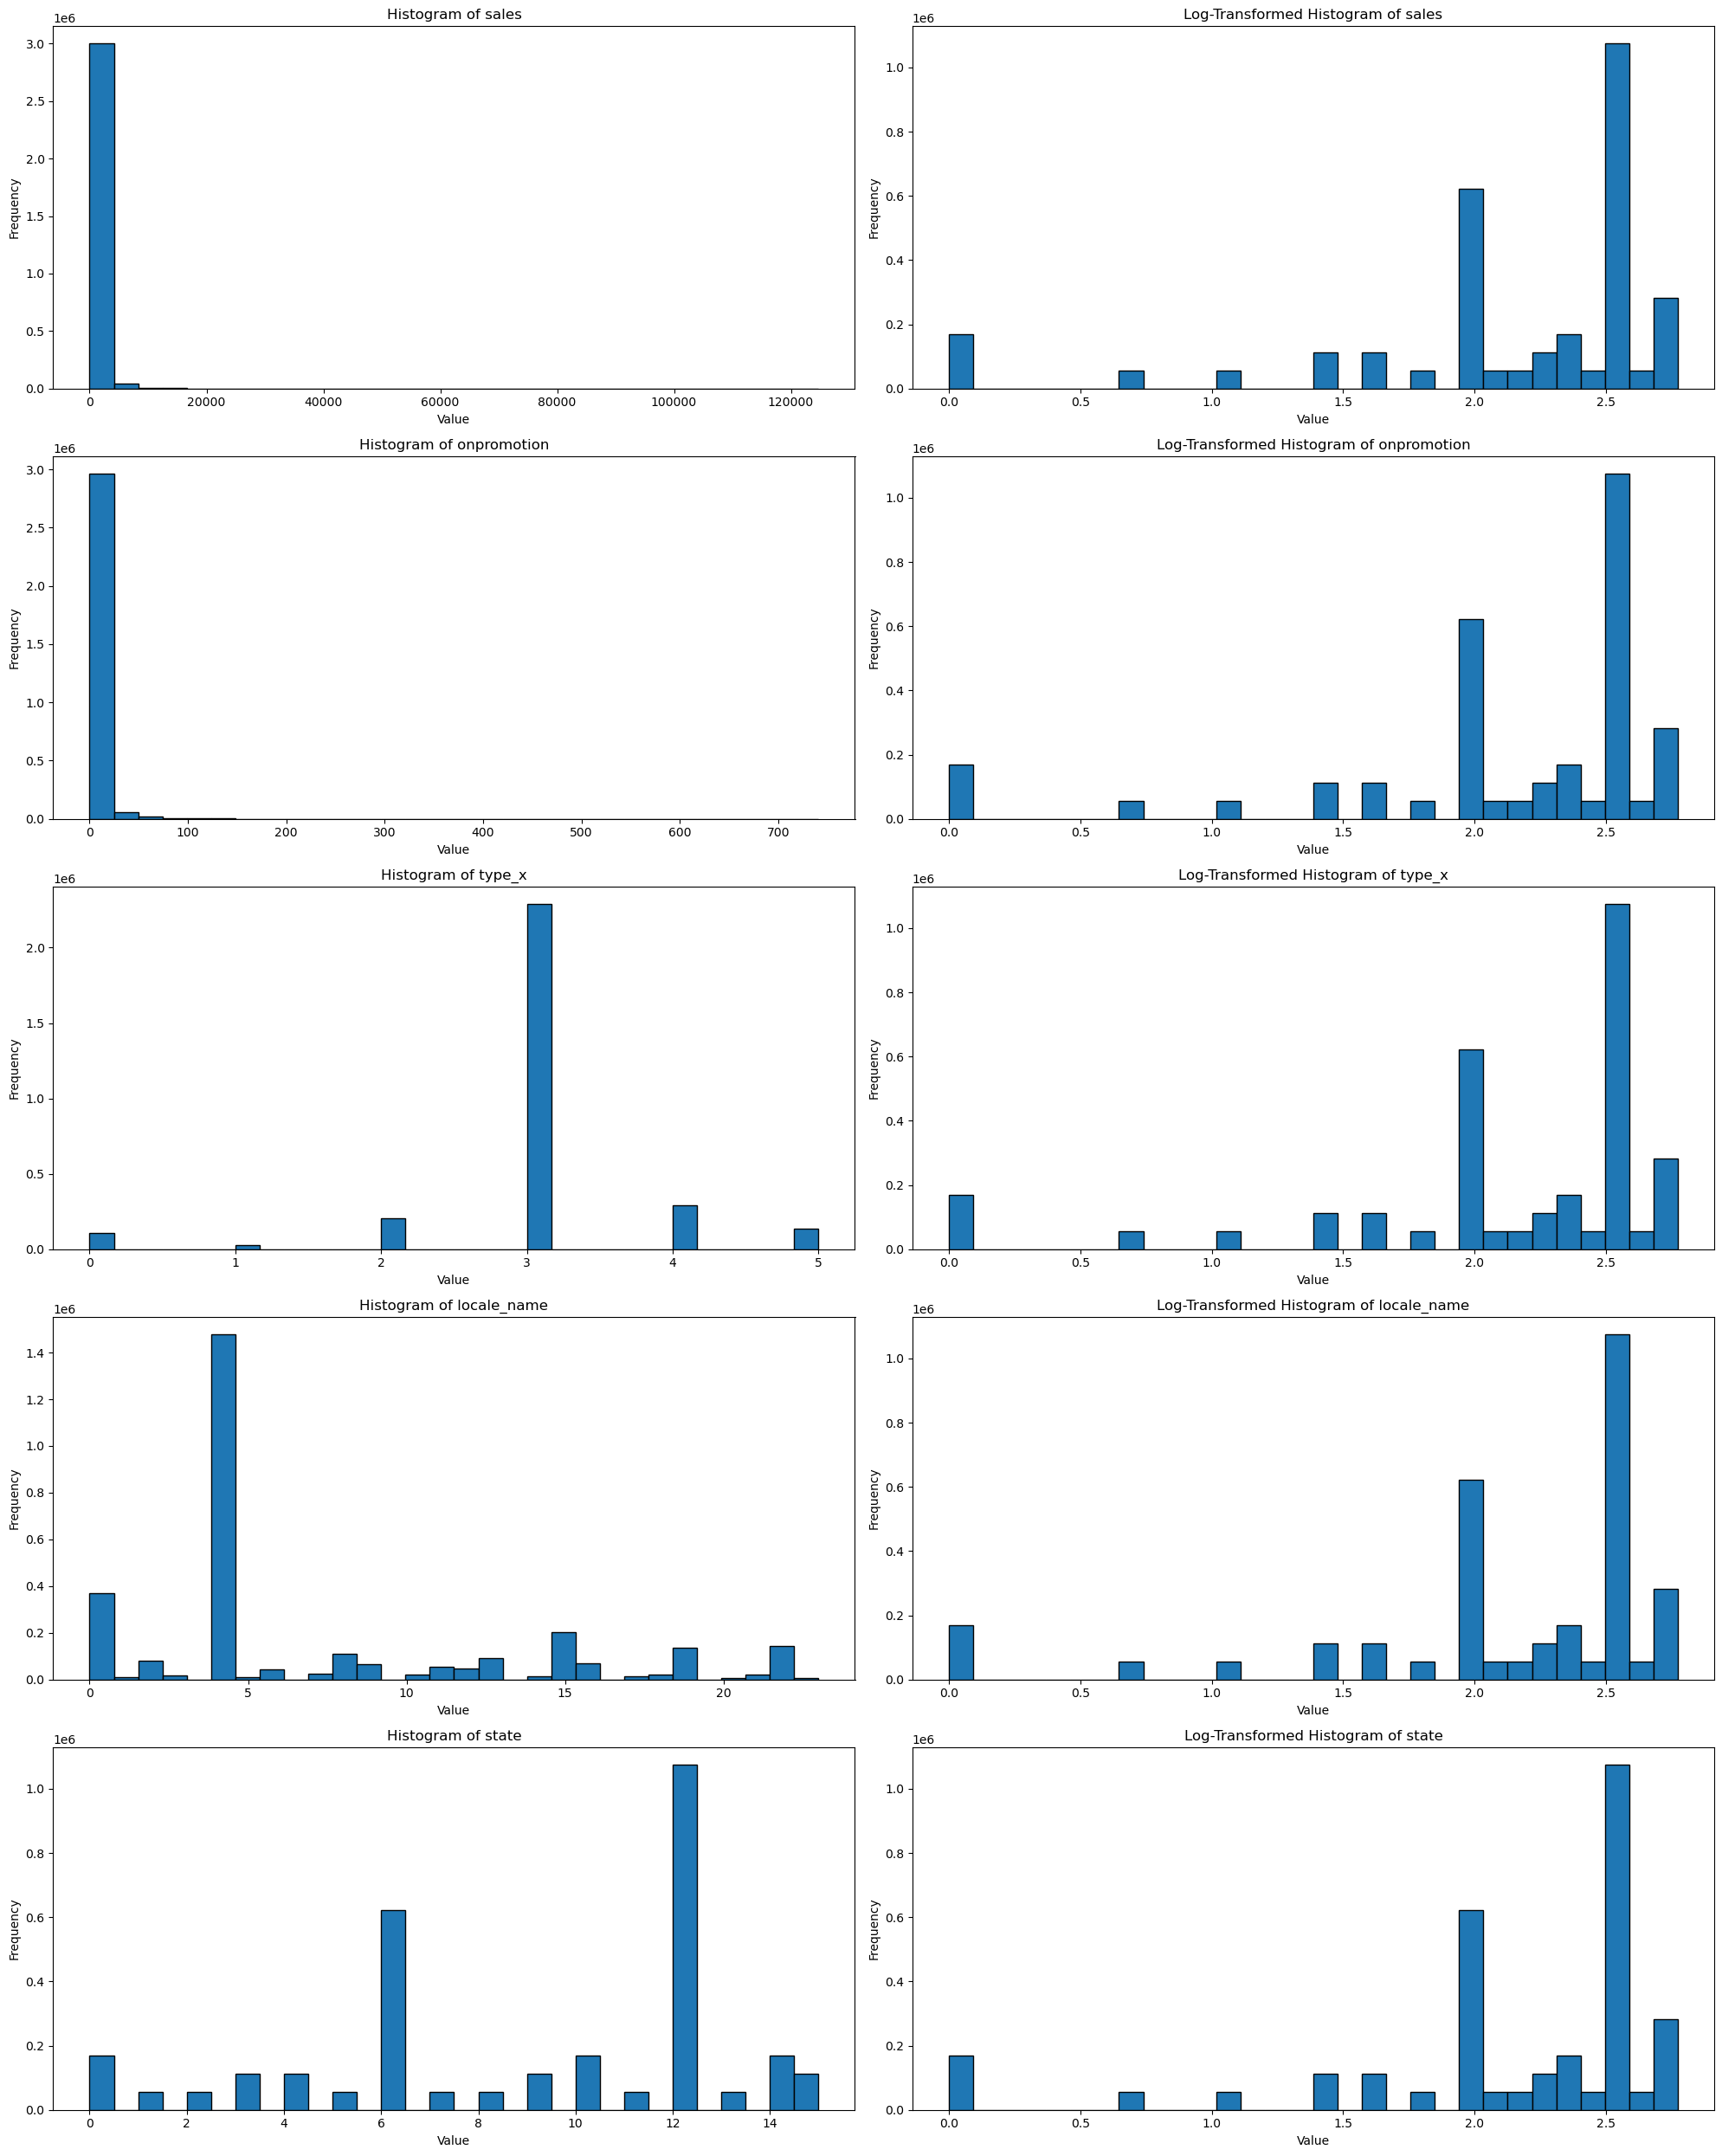

In [43]:
from sklearn.preprocessing import StandardScaler
def skewness_analyze(df, skew_threshold=0.5):
    """
    Takes a dataframe and returns a list of columns with skewness above the threshold
    """

    numerical_columns = df.select_dtypes(include=[np.number]).columns 
    # Drops binary columns to get accurate skewness processing
    numerical_columns = [col for col in numerical_columns if len(df[col].unique()) > 2 and sorted(df[col].unique()) != [0, 1]]
    skewed_features = []

    for column in numerical_columns:
        if abs(df[column].skew()) > skew_threshold:
            skewed_features.append(column)
    print(f"Total Skewed Features: {len(skewed_features)}")
    return skewed_features

def compare_skewed_preprocessing(df, skewed_columns, preprocessed: bool = False):
    """
    Takes a dataframe and list of columns with skewness above the threshold
    and plots histogram of non-processed skewed features.

    If "preprocessed" parameter is True, \
    it will plot histogram plot both skewed and non-skewed features.
    """
    n_features = len(skewed_columns)
    fig, axs = plt.subplots(n_features, 2, figsize=(20, n_features * 5))

    # Loop through each column and plot histogram of non-processed skewed features
    for i, col in enumerate(train_dataset[skewed_columns]):
        axs[i, 0].hist(train_dataset[col], bins=30, edgecolor='k')
        axs[i, 0].set_title(f'Histogram of {col}')
        axs[i, 0].set_xlabel('Value')
        axs[i, 0].set_ylabel('Frequency')

        if preprocessed: # Plot fixed skewed features
            _, transformed_col, _ = fix_skewness(df, skewed_columns)

            # Plot preprocessed feature
            axs[i, 1].hist(transformed_col, bins=30, edgecolor='k')
            axs[i, 1].set_title(f'Log-Transformed Histogram of {col}')
            axs[i, 1].set_xlabel('Value')
            axs[i, 1].set_ylabel('Frequency')
        

    plt.tight_layout()
    plt.show()

def fix_skewness(df, skewed_features):
    # Get non_skewed features
    non_skewed_features = set(df.columns) - set(skewed_features)
    scaler = StandardScaler()


    # Fix non-skewed features
    for col in non_skewed_features:
        non_skewed_features = scaler.fit_transform(df[col].values.reshape(-1, 1))

    # Fix skewed features
    for col in skewed_features:
        negative_indices = df[col] < 0
        transformed_col = np.log1p(np.abs(df[col]))
        skewed_features = np.where(negative_indices, -transformed_col, transformed_col)

    return df, skewed_features, non_skewed_features

skewed_columns = skewness_analyze(train_dataset)
compare_skewed_preprocessing(train_dataset, skewed_columns, preprocessed=True)

## Finish preprocessing

In [44]:
def extract_date(df, date_col):
    df[f'year {date_col}']           = df[date_col].dt.year.astype(int)
    df[f'month {date_col}']          = df[date_col].dt.month.astype(int)
    df[f'day {date_col}']            = df[date_col].dt.day.astype(int)
    df[f'day of week {date_col}']    = df[date_col].dt.dayofweek.astype(int)
    df[f'week of year {date_col}']   = df[date_col].dt.isocalendar().week.astype(int)
    df[f'quarter {date_col}']        = df[date_col].dt.quarter.astype(int)
    df[f'is weekend {date_col}']     = df[f'day of week {date_col}'].isin([5, 6]).astype(int)
    df[f'is leap year {date_col}']   = df[date_col].dt.is_leap_year.astype(int)
    df[f"is_month_end {date_col}"]   = df[date_col].dt.is_month_end.astype(int)
    df[f"is_month_start {date_col}"] = df[date_col].dt.is_month_start.astype(int)

In [45]:
def df_dtypes(df):
      pd.set_option('display.max_colwidth', None)
  
      df_dtypes = df.columns.groupby(df.dtypes)
      print(list(df_dtypes.keys()))
      df_dtypes = pd.DataFrame({
          'dtype':     list(df_dtypes.keys()),
          '# columns': [len(df_dtypes[key])  for key in df_dtypes.keys()],
          'columns':   [list(df_dtypes[key]) for key in df_dtypes.keys()],
      })
      df_dtypes = df_dtypes.style.applymap(lambda x:'text-align: left', subset=['columns'])
      return df_dtypes

df_dtypes(train_dataset)

[dtype('int64'), dtype('<M8[ns]'), dtype('bool'), dtype('int32'), dtype('float64')]


C:\Users\chupr\AppData\Local\Temp\ipykernel_29108\1507600715.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_dtypes = df_dtypes.style.applymap(lambda x:'text-align: left', subset=['columns'])


,dtype,# columns,columns
0,int64,5,"['id', 'store_nbr', 'onpromotion', 'transferred', 'cluster']"
1,datetime64[ns],1,['date']
2,bool,1,['WageDay']
3,int32,7,"['family', 'type_x', 'locale', 'locale_name', 'city', 'state', 'type_y']"
4,float64,2,"['sales', 'oil_price']"


In [46]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df):
    numerical_features = get_numerical_features(df)
    print(f'Categorical features: {categorical_features}')

    encoder = OneHotEncoder(drop='first', sparse_output=False)
    one_hot = encoder.fit_transform(df[categorical_features])
    hot_df = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out(categorical_features), index=df.index)
    print(hot_df.shape)
    df = df.drop(columns=categorical_features)
    df = pd.concat([df, hot_df], axis=1)
    return df


In [47]:
# Finish preprocessing
train_dataset.drop(columns=['id'], inplace=True)
test_data.drop(columns=['id'], inplace=True) 

extract_date(train_dataset, 'date') # type: ignore
extract_date(test_data, 'date') # type: ignore

# Replace true and false for 1 and 0 in transferred column
train_dataset['transferred'] = train_dataset['transferred'].astype(int)
train_dataset['WageDay'] = train_dataset['WageDay'].astype(int)
test_data['transferred'] = test_data['transferred'].astype(int)
test_data['WageDay'] = test_data['WageDay'].astype(int)

train_dataset = one_hot_encoding(train_dataset) # type: ignore
test_data = one_hot_encoding(test_data) # type: ignore

train_dataset.info()

Categorical features: ['family', 'type_x', 'locale', 'locale_name', 'transferred', 'city', 'state', 'type_y']
(3054348, 103)
Categorical features: ['family', 'type_x', 'locale', 'locale_name', 'transferred', 'city', 'state', 'type_y']
(28512, 73)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Columns: 120 entries, date to type_y_4
dtypes: datetime64[ns](1), float64(105), int32(11), int64(3)
memory usage: 2.6 GB


In [ ]:
df_dtypes(train_dataset)

[dtype('<M8[ns]'), dtype('int32'), dtype('int64'), dtype('float64')]


C:\Users\chupr\AppData\Local\Temp\ipykernel_29108\1507600715.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_dtypes = df_dtypes.style.applymap(lambda x:'text-align: left', subset=['columns'])


,dtype,# columns,columns
0,datetime64[ns],1,['date']
1,int32,11,"['WageDay', 'year date', 'month date', 'day date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date']"
2,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
3,float64,105,"['sales', 'oil_price', 'family_1', 'family_2', 'family_3', 'family_4', 'family_5', 'family_6', 'family_7', 'family_8', 'family_9', 'family_10', 'family_11', 'family_12', 'family_13', 'family_14', 'family_15', 'family_16', 'family_17', 'family_18', 'family_19', 'family_20', 'family_21', 'family_22', 'family_23', 'family_24', 'family_25', 'family_26', 'family_27', 'family_28', 'family_29', 'family_30', 'family_31', 'family_32', 'type_x_1', 'type_x_2', 'type_x_3', 'type_x_4', 'type_x_5', 'locale_1', 'locale_2', 'locale_name_1', 'locale_name_2', 'locale_name_3', 'locale_name_4', 'locale_name_5', 'locale_name_6', 'locale_name_7', 'locale_name_8', 'locale_name_9', 'locale_name_10', 'locale_name_11', 'locale_name_12', 'locale_name_13', 'locale_name_14', 'locale_name_15', 'locale_name_16', 'locale_name_17', 'locale_name_18', 'locale_name_19', 'locale_name_20', 'locale_name_21', 'locale_name_22', 'locale_name_23', 'transferred_1', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17', 'city_18', 'city_19', 'city_20', 'city_21', 'state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11', 'state_12', 'state_13', 'state_14', 'state_15', 'type_y_1', 'type_y_2', 'type_y_3', 'type_y_4']"


## Column alighnment with train and test sets 

In [ ]:
print(f"Number of columns in train dataset: {len(train_dataset.columns)}")
print(f"Number of columns in test dataset: {len(test_data.columns)}")

Number of columns in train dataset: 120
Number of columns in test dataset: 90


In [ ]:
def align_columns(train_dataset, test_data, fix_columns=False): # Fix columns parameter will set columns in the same order as in train dataset
    train_align, test_align = train_dataset.align(test_data, join='outer', axis=1)
    test_align = test_align.fillna(0)

    if fix_columns:
        train_align = train_align[train_dataset.columns]
        test_align = test_align[train_dataset.columns]

    return train_align, test_align

train_dataset, test_data = align_columns(train_dataset, test_data, fix_columns=True)
print(f"Number of columns in train dataset: {len(train_dataset.columns)}")
print(f"Number of columns in test dataset: {len(test_data.columns)}")

Number of columns in train dataset: 120
Number of columns in test dataset: 120


In [ ]:
train_dataset

,date,store_nbr,sales,onpromotion,oil_price,cluster,WageDay,year date,month date,day date,...,state_10,state_11,state_12,state_13,state_14,state_15,type_y_1,type_y_2,type_y_3,type_y_4
0,2013-01-01,1,0.000,0,93.13,13,0,2013,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2013-01-01,1,0.000,0,93.13,13,0,2013,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2013-01-01,1,0.000,0,93.13,13,0,2013,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2013-01-01,1,0.000,0,93.13,13,0,2013,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2013-01-01,1,0.000,0,93.13,13,0,2013,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,438.133,0,47.57,6,1,2017,8,15,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3054344,2017-08-15,9,154.553,1,47.57,6,1,2017,8,15,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3054345,2017-08-15,9,2419.729,148,47.57,6,1,2017,8,15,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3054346,2017-08-15,9,121.000,8,47.57,6,1,2017,8,15,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Split Dataset

In [ ]:
split = int(len(train_dataset) * 0.7)
train_dataset, validation_dataset = train_dataset[:split], train_dataset[split:]

len(train_dataset), len(validation_dataset)

(2138043, 916305)

Three ways to organize our data: 
- 1. Do nothing. Leave the data unbalanced, we are getting more samples, but the predictions are awful and not correct.
- 2. Delete all zero sales. Good way, but then there's no probability for zeros. 
- 3. Leave a small percent of all zeros in our dataset. So when we are going to predict, the model will also count the probabilities of data to be zero sales. 

In [ ]:
# How much zero sales in our dataset? # How much sales > 0 in our dataset?
len(train_dataset[train_dataset["sales"] == 0]), len(train_dataset[train_dataset["sales"] > 0])

(799769, 1338274)

In [ ]:
def method_preprocessing(dataset, method: int): 
    # Method 1: Do nothing
    if method == 1: 
        return dataset
    elif method == 2: 
        # Delete all zero sales. Good way, but then there's no probability for zeros.
        dataset = dataset[dataset["sales"] > 0] 
        return dataset
    elif method == 3: 
        # Leave 10% of all zeros in our dataset.  
        zero_sales = dataset[dataset['sales'] == 0]
        non_zero_sales = dataset[dataset['sales'] > 0]

        # Undersample the zero sales data to 20%
        zero_sales = zero_sales.sample(frac=0.2, random_state=42)

        # Combine the undersampled zero sales with the non-zero sales
        dataset = pd.concat([zero_sales, non_zero_sales])

        # Shuffle the data
        dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

        # Sort by the date 
        dataset = dataset.sort_values(by='date').reset_index(drop=True)
        
        return dataset
    else: 
        raise ValueError(f"Method {method} is not implemented.")

In [ ]:
train_dataset = method_preprocessing(train_dataset, method=3)

# Length after undersampling
len(train_dataset[train_dataset["sales"] == 0]), len(train_dataset[train_dataset["sales"] > 0])

(159954, 1338274)

In [ ]:
## Are there are missing values? 
train_dataset.isnull().sum().sum()

0

# Save processed data 

** All the datasets weight ~2.7 Gb **

In [ ]:
def memory_usage(dfs): 
    def calculate_memory_usage(df):
        mem_usage_bytes = df.memory_usage(deep=True).sum()
        mem_usage_gb = mem_usage_bytes / (1024 ** 3)
        return mem_usage_gb

    
    if isinstance(dfs, dict):
        for name, df in dfs.items():
            mem_usage_gb = calculate_memory_usage(pd.DataFrame(df))
            print(f"{name} memory usage in gigabytes: {mem_usage_gb:.2f} GB")
    else:
        mem_usage_gb = calculate_memory_usage(dfs)
        print(f"Memory usage in gigabytes: {mem_usage_gb:.2f} GB")
        return {"gigabytes": mem_usage_gb}

    
# Accepts a dictionary of dataframe
memory_usage({
    "train_dataset": train_dataset,
    "validation_dataset": validation_dataset,
    "test_dataset": test_data})

train_dataset memory usage in gigabytes: 1.28 GB
validation_dataset memory usage in gigabytes: 0.78 GB
test_dataset memory usage in gigabytes: 0.02 GB


In [ ]:
train_file = r"preprocessed_dataset\test_dataset.csv"

# Save data
if not os.path.exists(train_file): 
    train_dataset = train_dataset.to_csv(r'preprocessed_dataset\train_dataset.csv', index=False)
    # No sampling for validation_dataset for correct evaluation.
    validation_dataset = validation_dataset.to_csv(r'preprocessed_dataset\validation_dataset.csv', index=False)
    test_data = test_data.to_csv(r'preprocessed_dataset\test_dataset.csv', index=False)
    print(f"Data was succesfully saved.")
else: 
    print(f'File {train_file} already exists and will not be overwritten.')

File preprocessed_dataset\test_dataset.csv already exists and will not be overwritten.
